# Quick and Dirty Model Creation For Testing iOS App

> Heavily borrowed from: https://www.kaggle.com/code/pavanyekabote/driver-activity-detection-py

All generated outputs (figures and model files) are stored in ../output folder.
## What This Notebook Does
* Basic Data visualization used in project proposal
* Build CNN model by 
  * Creating a VGG16 model
  * Initialize model with pretrained weights from [VGG16 weights](https://github.com/zdata-inc/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5)
  * Fine tune the model by training on a subset of the driver activity images (about 600 images per class compared to the original 2000+ images)
* Convert the trained model for iOS app and export it

## Prerequisites for this notebook:
* Download [distrated driver dataset from kaggle](https://www.kaggle.com/competitions/state-farm-distracted-driver-detection/data) to `../input/`
* Download the [VGG16 weights to](https://github.com/zdata-inc/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5) `../input/vgg16-weights/`


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import sys

import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')

from tensorflow import keras
import numpy
from PIL import Image
import functools
import coremltools as ct
import seaborn as sns

from tensorflow.keras.layers import ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
from tensorflow.keras.models import load_model
import coremltools

import preprocessor
import configuration
import viz

preproc = preprocessor.PreProcessor()
config = configuration.Configuration()


TensorFlow version: 2.10.1


In [5]:
# Helper methods
# Ref: https://coremltools.readme.io/docs/introductory-quickstart
def convert_tf_saved_model(in_model_file, out_model_file):
    # Define the input type as image, 
    # set pre-processing parameters to normalize the image 
    # to have its values in the interval [-1,1] 
    # as expected by the mobilenet model
    image_input = coremltools.ImageType(shape=(1, 224, 224, 3,),
                               bias=[-1,-1,-1], scale=1/255.)

    # set class labels
    class_labels = list(config.class_dict.values())
    
    classifier_config = coremltools.ClassifierConfig(class_labels)

    model = load_model(in_model_file)
    
    print("[INFO] converting model")
    coreml_model = coremltools.convert(
        model, 
        inputs=[image_input], 
        classifier_config=classifier_config,
    )    

    print("[INFO] saving model")
    coreml_model.save(out_model_file)

<a id="step0"></a>
## Import Datasets

### Import Driver Dataset

In the following code cell, we create a instance of ImageDataGenerator which does all preprocessing operations on images that we are going to feed to our CNN

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In the following code, we are loading only 32 images at once into memory and performing all the preprocessing operations on loaded images. The flow_from_directory loads a defined set of images from the location of images, instead of loading all images at once into memory.

- train_generator contains training set
- val_generator contains validation set

In [7]:
TRAIN_DATA_LOC = f'{config.INPUT_FOLDER}/state-farm-distracted-driver-detection/imgs/train_cnn'
train_generator = train_datagen.flow_from_directory(
        TRAIN_DATA_LOC,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training')

val_generator = train_datagen.flow_from_directory(
        TRAIN_DATA_LOC,
        target_size=(224,224),
        batch_size=32,
        class_mode='categorical',
        subset='validation')


Found 4800 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.


In [8]:
imgs, labels = next(train_generator)

---
<a id="step2"></a>
## Train a CNN with Transfer Learning (Using Fine-tuned VGG16 Model)

- In the following steps, we are going to load a VGG16 model, without top Fully connected layers, with its trained weights
- Then we are going add Fully Connected Layers on top of GlobalAveragePooling layer with Dropout layers in between
- The following code block contains a method load_VGG16, which loads VGG16 model with weights loaded when weights file location is given

In [9]:

def load_VGG16(weights_path=None, no_top=True):

    input_shape = (224, 224, 3)

    #Instantiate an empty model
    img_input = Input(shape=input_shape)   # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    x = GlobalAveragePooling2D()(x)
    vmodel = Model(img_input, x, name='vgg16')
    if weights_path is not None:
        print("Weights have been loaded.")
        vmodel.load_weights(weights_path)

    return vmodel


- In the following code block, we have added 3 Dense layers with dropout layers on top of VGG16 CNN model.

In [10]:
vgg_model_raw = load_VGG16(f'{config.INPUT_FOLDER}/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
vgg_model = vgg_model_raw.output
vgg_model = Dense(5000, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(vgg_model)
vgg_model = Dropout(0.1)(vgg_model)
vgg_model = Dense(500, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(vgg_model)
vgg_model = Dropout(0.1)(vgg_model)
vgg_model = Dense(10, activation='softmax')(vgg_model)
vgg_m = Model(inputs=vgg_model_raw.input, outputs= vgg_model)

Metal device set to: AMD Radeon Pro 5300M
Weights have been loaded.


### Compile the vgg16 model with categorical crossentropy as loss function and SGD as optimizer

In [11]:
vgg_m.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(0.001), metrics=['accuracy'])


In [12]:
vgg_m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
checkpoint = ModelCheckpoint('vgg_model.h5', save_best_only=True, verbose=1)

history = vgg_m.fit(train_generator, steps_per_epoch=len(train_generator),
                   epochs=12,
                   validation_data = val_generator,
                   validation_steps=len(val_generator),
                   callbacks=[checkpoint] )

Epoch 1/12
150/150 [==============================] - ETA: 0s - loss: 2.3282 - accuracy: 0.1067
Epoch 1: val_loss improved from inf to 2.31301, saving model to vgg_model.h5
150/150 [==============================] - 389s 3s/step - loss: 2.3282 - accuracy: 0.1067 - val_loss: 2.3130 - val_accuracy: 0.1267
Epoch 2/12
150/150 [==============================] - ETA: 0s - loss: 2.3091 - accuracy: 0.1346
Epoch 2: val_loss improved from 2.31301 to 2.29843, saving model to vgg_model.h5
150/150 [==============================] - 479s 3s/step - loss: 2.3091 - accuracy: 0.1346 - val_loss: 2.2984 - val_accuracy: 0.2433
Epoch 3/12
150/150 [==============================] - ETA: 0s - loss: 2.2932 - accuracy: 0.1621
Epoch 3: val_loss improved from 2.29843 to 2.27954, saving model to vgg_model.h5
150/150 [==============================] - 438s 3s/step - loss: 2.2932 - accuracy: 0.1621 - val_loss: 2.2795 - val_accuracy: 0.2625
Epoch 4/12
150/150 [==============================] - ETA: 0s - loss: 2.2606 

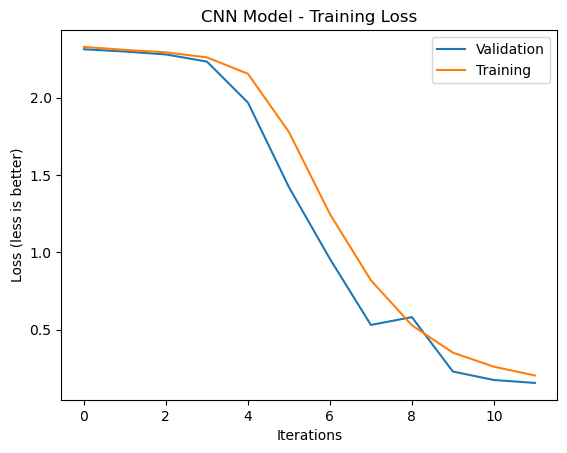

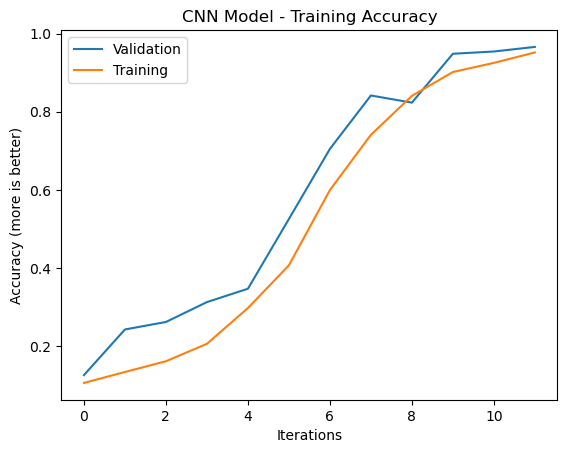

In [16]:
plt.plot(history.history['val_loss'], label='Validation')
plt.plot(history.history['loss'], label='Training')
plt.title('CNN Model - Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss (less is better)')
plt.legend()
plt.show()
plt.plot(history.history['val_accuracy'], label='Validation')
plt.plot(history.history['accuracy'], label='Training')
plt.title('CNN Model - Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (more is better)')
plt.legend()
plt.show()


In [ ]:
# Save the model as pb file
vgg_m.save(f'{config.SAVED_MODELS_FOLDER}/vgg_model_tf_saved')

In [ ]:
# Convert the saved model to CoreML for inferencing within iOS app.
# convert_tf_saved_model(f'{config.OUTPUT_FOLDER}/vgg_model_tf_saved', out_model_file=f'{config.OUTPUT_FOLDER}/DriverDistractionVggClassifier.mlmodel')